In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import math
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold,train_test_split,GridSearchCV,learning_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve,auc,accuracy_score,confusion_matrix
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
plt.rc("font",family="SimHei",size="15")  
pd.set_option('display.precision',4)
sns.set_theme(style="whitegrid", palette="husl")
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e8/sample_submission.csv
/kaggle/input/playground-series-s5e8/train.csv
/kaggle/input/playground-series-s5e8/test.csv
/kaggle/input/bank-marketing-dataset-full/bank-full.csv


In [2]:
#import numpy as np
#import pandas as pd


In [3]:
train_backup = pd.read_csv('/kaggle/input/playground-series-s5e8/train.csv', index_col='id')
test_backup = pd.read_csv('/kaggle/input/playground-series-s5e8/test.csv', index_col='id')

In [4]:
train_df = pd.read_csv('/kaggle/input/playground-series-s5e8/train.csv', index_col='id')
test_df = pd.read_csv('/kaggle/input/playground-series-s5e8/test.csv', index_col='id')

In [5]:
orig_df = pd.read_csv("/kaggle/input/bank-marketing-dataset-full/bank-full.csv", sep=';')
orig_df['y'] = orig_df['y'].map({'no': 0, 'yes': 1})

In [6]:
train_df = pd.concat([train_df, orig_df], ignore_index=True)
train_df = train_df.drop_duplicates()

In [7]:
train_df.head(10)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,42,technician,married,secondary,no,7,no,no,cellular,25,aug,117,3,-1,0,unknown,0
1,38,blue-collar,married,secondary,no,514,no,no,unknown,18,jun,185,1,-1,0,unknown,0
2,36,blue-collar,married,secondary,no,602,yes,no,unknown,14,may,111,2,-1,0,unknown,0
3,27,student,single,secondary,no,34,yes,no,unknown,28,may,10,2,-1,0,unknown,0
4,26,technician,married,secondary,no,889,yes,no,cellular,3,feb,902,1,-1,0,unknown,1
5,24,admin.,single,secondary,no,1882,yes,no,cellular,20,apr,1010,3,-1,0,unknown,0
6,39,blue-collar,married,secondary,no,0,no,no,telephone,21,nov,90,1,-1,0,unknown,0
7,50,admin.,single,secondary,no,1595,no,no,telephone,31,jul,49,25,-1,0,unknown,0
8,46,blue-collar,married,primary,no,1463,no,no,cellular,4,aug,50,1,-1,0,unknown,0
9,39,management,divorced,tertiary,no,25,yes,no,cellular,8,may,119,1,-1,0,unknown,0


In [8]:
test_df.head(10)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
id,,,,,,,,,,,,,,,,
750000,32,blue-collar,married,secondary,no,1397,yes,no,unknown,21,may,224,1,-1,0,unknown
750001,44,management,married,tertiary,no,23,yes,no,cellular,3,apr,586,2,-1,0,unknown
750002,36,self-employed,married,primary,no,46,yes,yes,cellular,13,may,111,2,-1,0,unknown
750003,58,blue-collar,married,secondary,no,-1380,yes,yes,unknown,29,may,125,1,-1,0,unknown
750004,28,technician,single,secondary,no,1950,yes,no,cellular,22,jul,181,1,-1,0,unknown
750005,43,management,divorced,unknown,no,3025,no,no,cellular,21,jul,89,2,-1,0,unknown
750006,26,services,single,primary,no,3511,no,no,cellular,29,jan,816,3,-1,0,unknown
750007,60,management,married,tertiary,no,79,no,yes,cellular,9,jul,707,1,-1,0,unknown
750008,45,blue-collar,married,primary,no,16,no,no,telephone,6,feb,173,1,-1,0,unknown


In [9]:
train_df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')

In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 795211 entries, 0 to 795210
Data columns (total 17 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   age        795211 non-null  int64 
 1   job        795211 non-null  object
 2   marital    795211 non-null  object
 3   education  795211 non-null  object
 4   default    795211 non-null  object
 5   balance    795211 non-null  int64 
 6   housing    795211 non-null  object
 7   loan       795211 non-null  object
 8   contact    795211 non-null  object
 9   day        795211 non-null  int64 
 10  month      795211 non-null  object
 11  duration   795211 non-null  int64 
 12  campaign   795211 non-null  int64 
 13  pdays      795211 non-null  int64 
 14  previous   795211 non-null  int64 
 15  poutcome   795211 non-null  object
 16  y          795211 non-null  int64 
dtypes: int64(8), object(9)
memory usage: 103.1+ MB


In [11]:
train_df.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [12]:
train_df.describe().style.format('{:.3f}')

,age,balance,day,duration,campaign,pdays,previous,y
count,795211.000,795211.000,795211.000,795211.000,795211.000,795211.000,795211.000,795211.000
mean,40.927,1213.062,16.100,256.339,2.588,23.424,0.315,0.120
std,10.129,2848.604,8.255,271.724,2.742,78.901,1.410,0.325
min,18.000,-8019.000,1.000,0.000,1.000,-1.000,0.000,0.000
25%,33.000,0.000,9.000,91.000,1.000,-1.000,0.000,0.000
50%,39.000,624.000,17.000,135.000,2.000,-1.000,0.000,0.000
75%,48.000,1390.000,21.000,347.500,3.000,-1.000,0.000,0.000
max,95.000,102127.000,31.000,4918.000,63.000,871.000,275.000,1.000


In [13]:
sample_submission = pd.read_csv('/kaggle/input/playground-series-s5e8/sample_submission.csv')
sample_submission.head(10)

,id,y
0,750000,0.5
1,750001,0.5
2,750002,0.5
3,750003,0.5
4,750004,0.5
5,750005,0.5
6,750006,0.5
7,750007,0.5
8,750008,0.5
9,750009,0.5


In [14]:
train_num_df = train_df.select_dtypes(include='number') #.drop(columns=['id'])
train_num_df.corr().style.format('{:.4f}')

,age,balance,day,duration,campaign,pdays,previous,y
age,1.0000,0.0651,-0.0148,-0.0044,0.0022,-0.0217,0.0042,0.0104
balance,0.0651,1.0000,-0.0076,0.1045,-0.0266,0.0102,0.0324,0.1183
day,-0.0148,-0.0076,1.0000,-0.0553,0.1775,-0.0868,-0.0509,-0.0484
duration,-0.0044,0.1045,-0.0553,1.0000,-0.0830,0.0441,0.0361,0.5126
campaign,0.0022,-0.0266,0.1775,-0.0830,1.0000,-0.0627,-0.0264,-0.0756
pdays,-0.0217,0.0102,-0.0868,0.0441,-0.0627,1.0000,0.5479,0.0898
previous,0.0042,0.0324,-0.0509,0.0361,-0.0264,0.5479,1.0000,0.1153
y,0.0104,0.1183,-0.0484,0.5126,-0.0756,0.0898,0.1153,1.0000


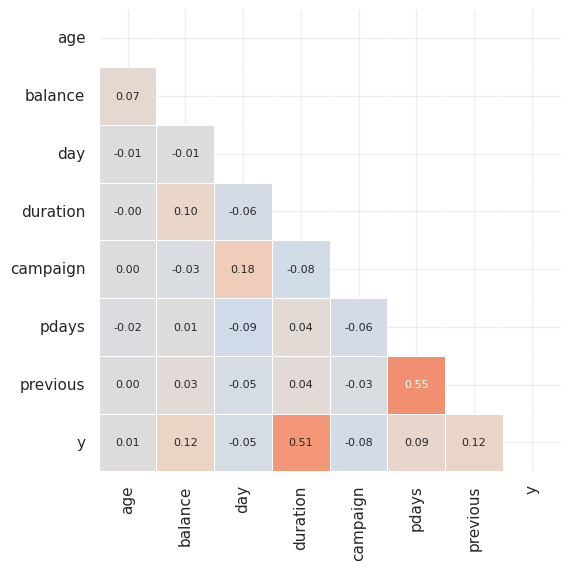

In [15]:
mask = np.triu(np.ones_like(train_num_df.corr(), dtype=bool))
plt.figure(figsize = (8,6))
plt.rcParams.update({'font.size': 12})
sns.heatmap(train_num_df.corr(), cmap = 'coolwarm', vmin = -1, 
            vmax = 1, center = 0, annot=True, fmt=".2f", square=True, linewidths=.5, mask = mask,
             annot_kws={'size': 8}, cbar=False
           )
plt.show()


<Axes: title={'center': 'Boxplot'}>

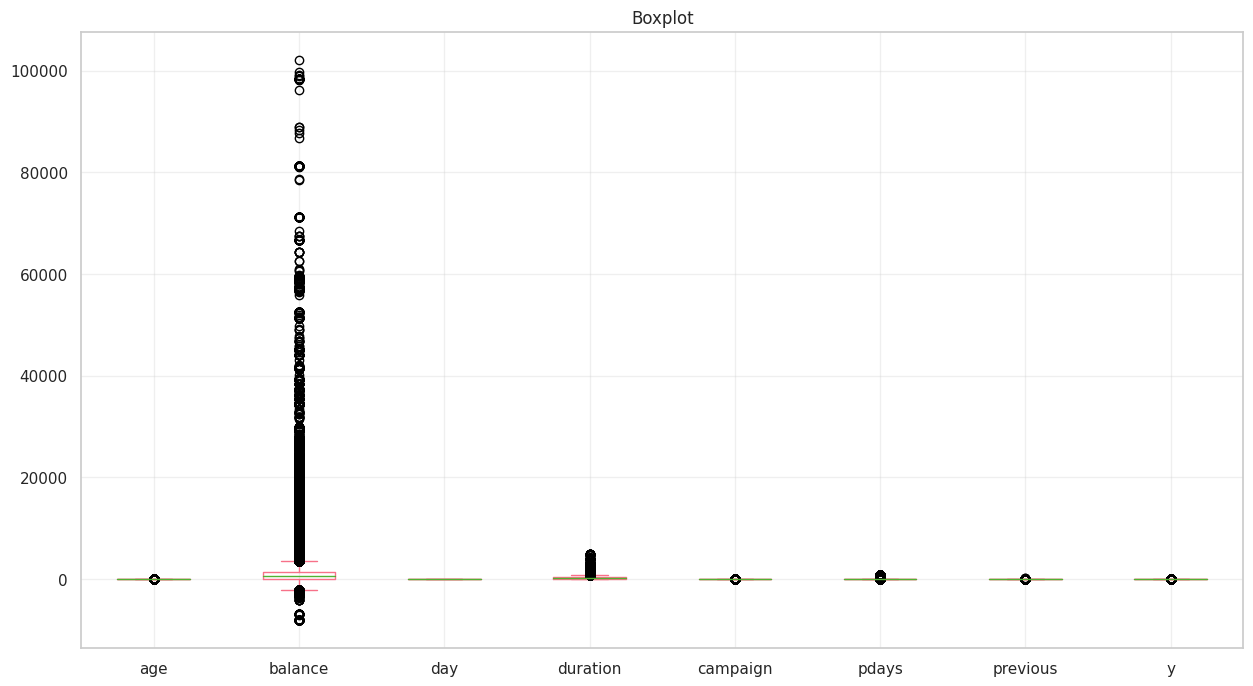

In [16]:
train_num_df.plot(kind='box', title='Boxplot', figsize=(15, 8))

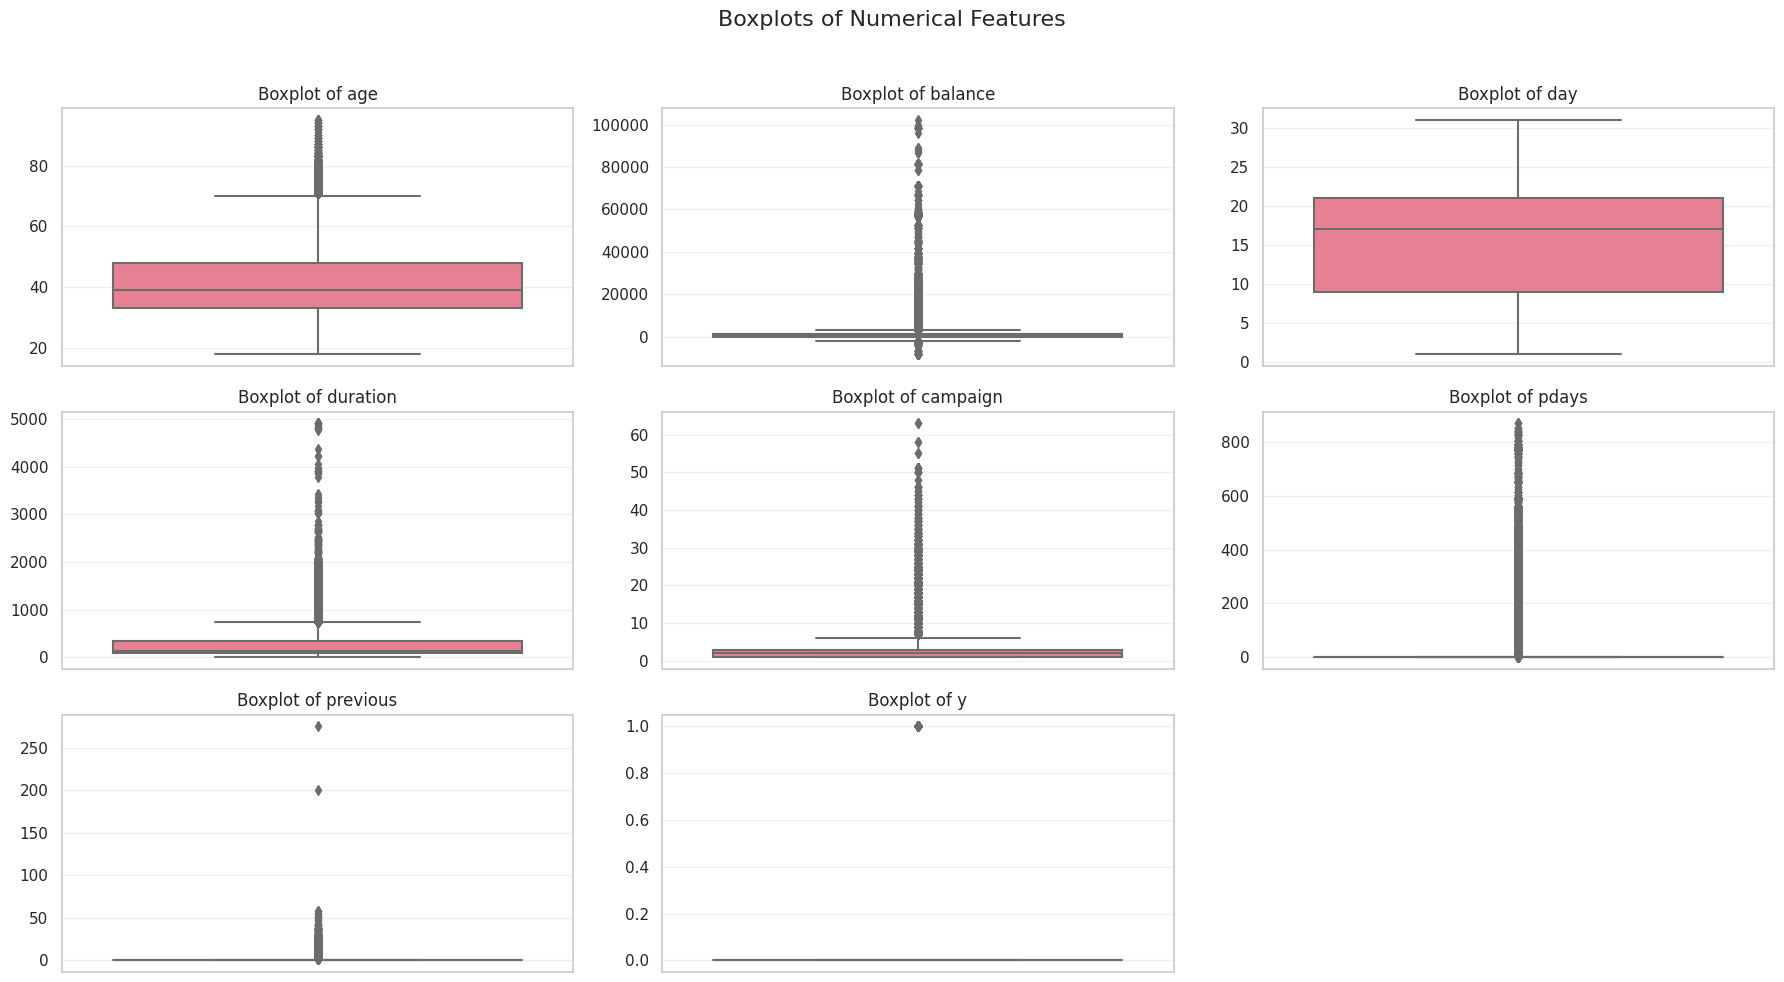

In [17]:
num_cols = len(train_num_df.columns)
n_cols = 3
n_rows = math.ceil(num_cols / n_cols)

# 2. Create the figure and axes objects
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 10))
# Flatten the axes array to make it easy to iterate over
axes = axes.flatten()

# 3. Loop through the columns and plot
for i, col in enumerate(train_num_df.columns):
    sns.boxplot(y=col, data=train_num_df, ax=axes[i], orient='v')
    axes[i].set_title(f'Boxplot of {col}')
    axes[i].set_ylabel('') # Optional: remove y-label for cleaner look

# 4. Remove any unused subplots
for i in range(num_cols, len(axes)):
    fig.delaxes(axes[i])

# 5. Add a main title and adjust layout
fig.suptitle('Boxplots of Numerical Features', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust rect to make space for suptitle
plt.show()

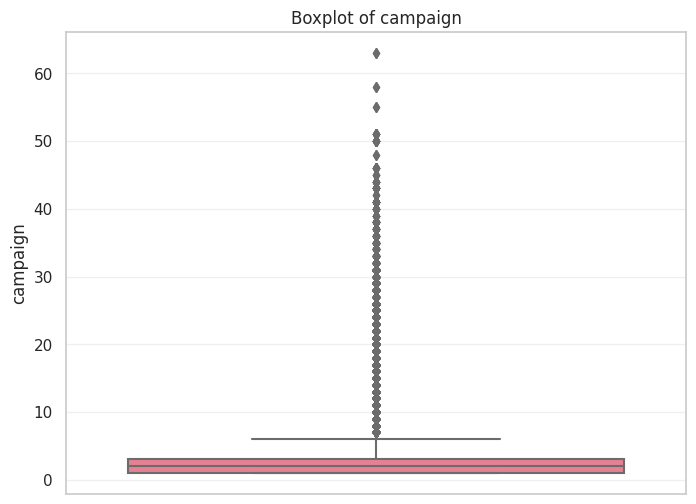

In [18]:
# Logic for extreme outlier case
plt.figure(figsize=(8, 6))
sns.boxplot(y='campaign', data=train_num_df)
plt.title('Boxplot of campaign')
plt.show()

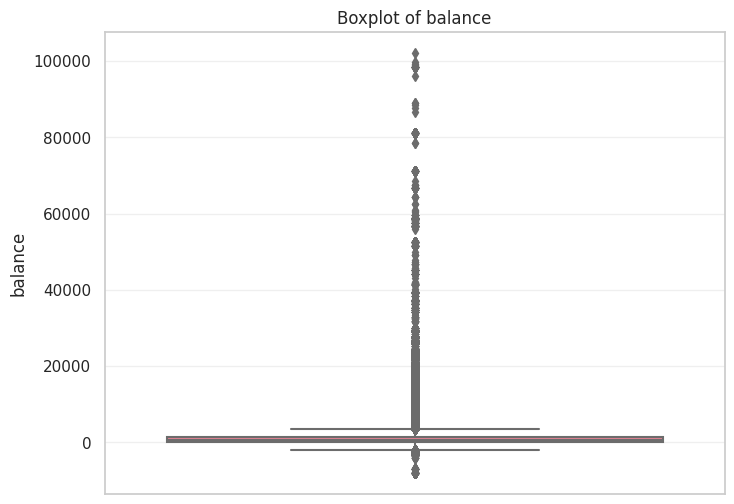

In [19]:
# Logic for extreme outlier case
plt.figure(figsize=(8, 6))
sns.boxplot(y='balance', data=train_num_df)
plt.title('Boxplot of balance')
plt.show()

In [20]:
other_cols = train_num_df.drop(columns=['campaign','balance'])


In [21]:
def custom_describe(df):
    df1 = df.select_dtypes(include=np.number)
    des = df1.describe().T
    des['skewness'] = df1.skew()
    des['kurtosis'] = df1.kurtosis()
    des['count'] = des['count'].astype('int')
    return des

In [22]:
features = test_df.columns.tolist()
print(features)

['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome']


In [23]:
train_df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,42,technician,married,secondary,no,7,no,no,cellular,25,aug,117,3,-1,0,unknown,0
1,38,blue-collar,married,secondary,no,514,no,no,unknown,18,jun,185,1,-1,0,unknown,0
2,36,blue-collar,married,secondary,no,602,yes,no,unknown,14,may,111,2,-1,0,unknown,0
3,27,student,single,secondary,no,34,yes,no,unknown,28,may,10,2,-1,0,unknown,0
4,26,technician,married,secondary,no,889,yes,no,cellular,3,feb,902,1,-1,0,unknown,1


In [24]:
#train_df.iloc[:-1].select_dtypes(include=np.number).columns

In [25]:
numerical_features = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'day', 'month', 'poutcome']
target = 'y'

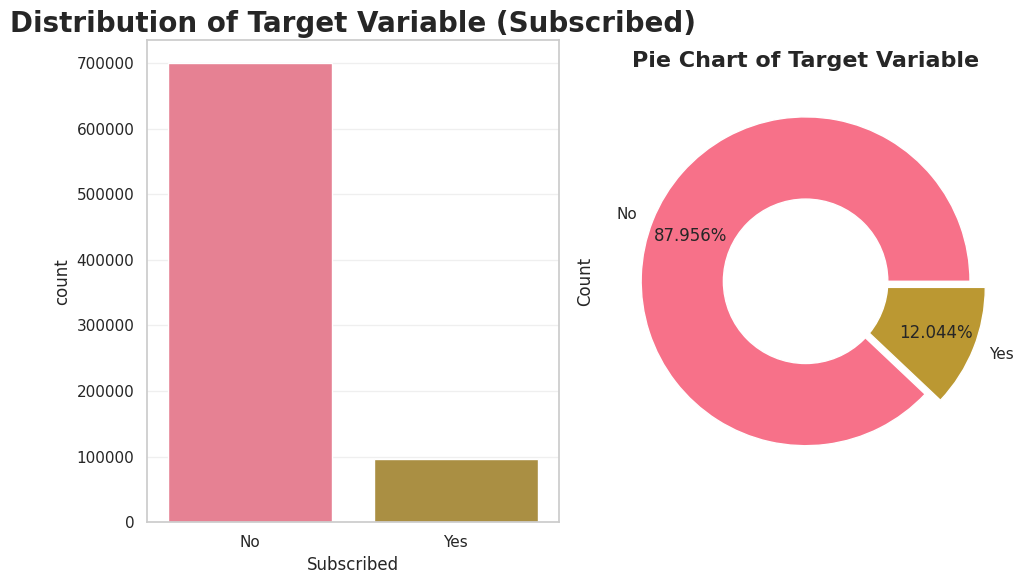

In [26]:
fig, axes = plt.subplots(1,2,figsize = (10,6))
sns.countplot(x=target,data = train_df, ax= axes[0])
axes[0].set_title('Distribution of Target Variable (Subscribed)',fontweight= 'bold', size = 20)
axes[0].set_xticks(ticks = [0 , 1], labels=['No','Yes'])
axes[0].set_xlabel('Subscribed')

train_df['y'].value_counts().plot(kind = 'pie',ax = axes[1],explode = (0.0,0.1),autopct = "%.3f%%",
labels=['No','Yes'],pctdistance = 0.75)
axes[1].add_artist(plt.Circle((0,0),0.5,fc='w'))
axes[1].set_title('Pie Chart of Target Variable',fontweight='bold',size= 16)
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()

In [27]:
custom_describe(train_df)

,count,mean,std,min,25%,50%,75%,max,skewness,kurtosis
age,795211,40.9270,10.1291,18.0,33.0,39.0,48.0,95.0,0.5927,-0.0411
balance,795211,1213.0620,2848.6039,-8019.0,0.0,624.0,1390.0,102127.0,12.0341,259.5774
day,795211,16.0995,8.2552,1.0,9.0,17.0,21.0,31.0,0.0562,-1.0455
duration,795211,256.3391,271.7238,0.0,91.0,135.0,347.5,4918.0,2.1022,6.9788
campaign,795211,2.5876,2.7418,1.0,1.0,2.0,3.0,63.0,4.8271,37.8595
pdays,795211,23.4239,78.9015,-1.0,-1.0,-1.0,-1.0,871.0,3.5455,13.0205
previous,795211,0.3146,1.4104,0.0,0.0,0.0,0.0,275.0,21.4424,2453.4858
y,795211,0.1204,0.3255,0.0,0.0,0.0,0.0,1.0,2.3323,3.4397


In [28]:
def numerical_features_plot(df, feature, target):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f'Analysis of {feature}', fontsize=16, fontweight='bold')

    # Boxplot
    sns.boxplot(data=df, x=feature, y=target, hue=target, orient='h', ax=axes[0])
    axes[0].set_title(f'Boxplot of {feature}')
    axes[0].legend_.remove()  # Turn off legend

    # Violinplot
    sns.violinplot(data=df, x=feature, y=target, hue=target, orient='h', ax=axes[1])
    axes[1].set_title(f'Violinplot of {feature}')
    axes[1].legend_.remove()  # Turn off legend

    # Histogram with KDE
    sns.histplot(data=df, x=feature, hue=target, kde=True, ax=axes[2], alpha=0.6)
    axes[2].set_title(f'Distribution of {feature}')

    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

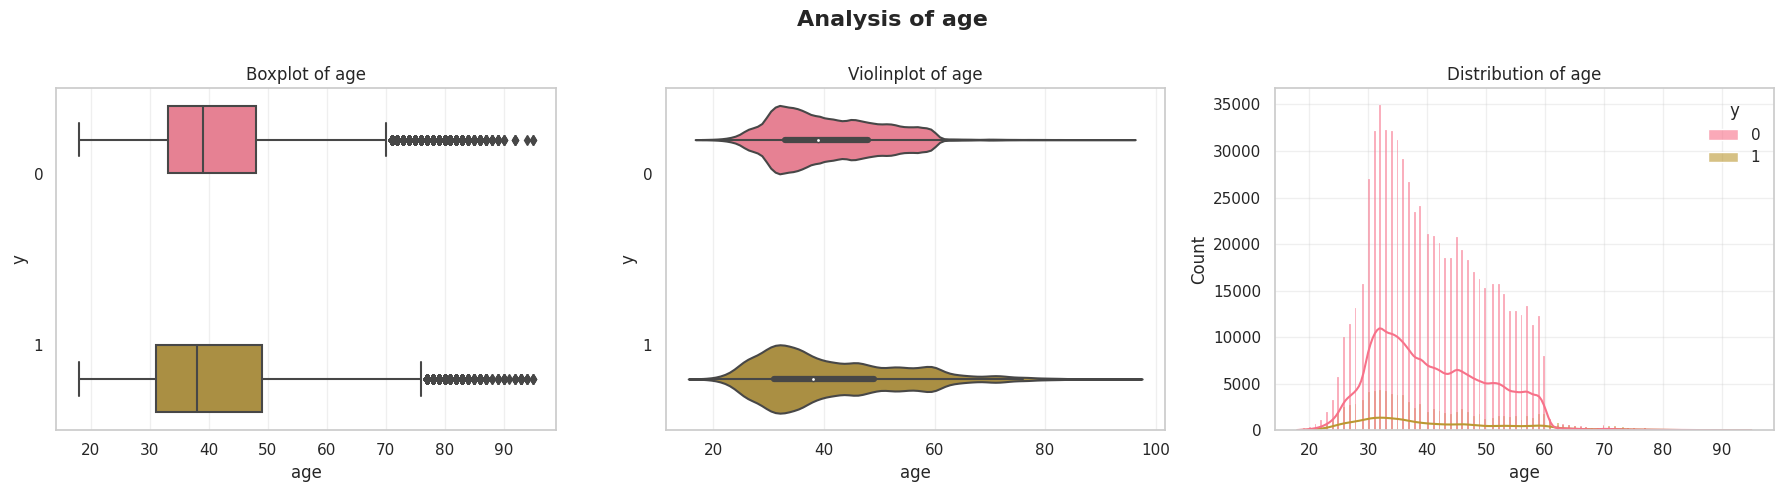

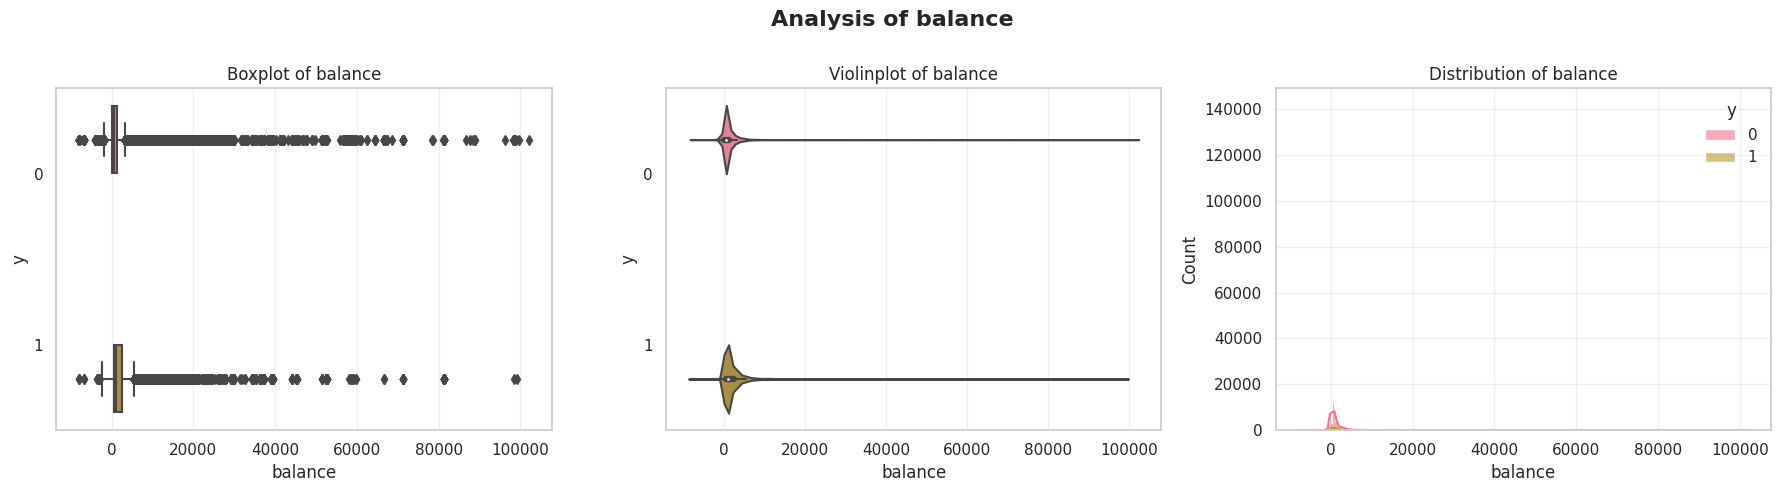

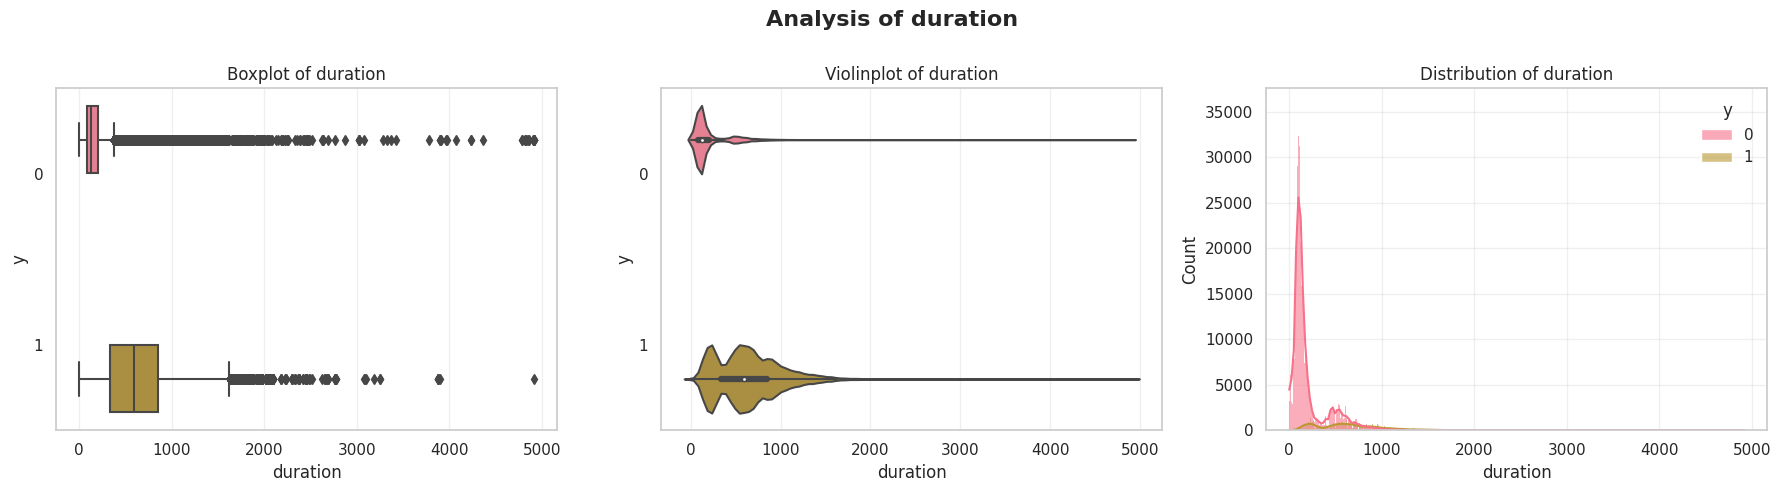

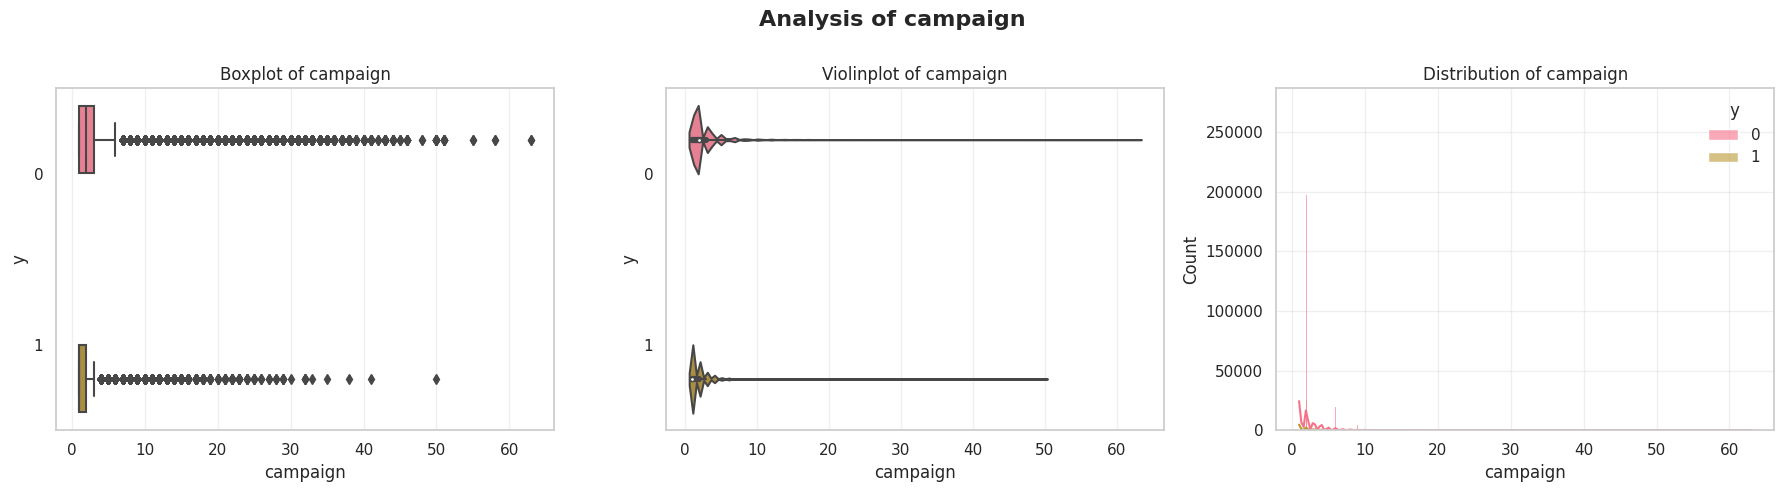

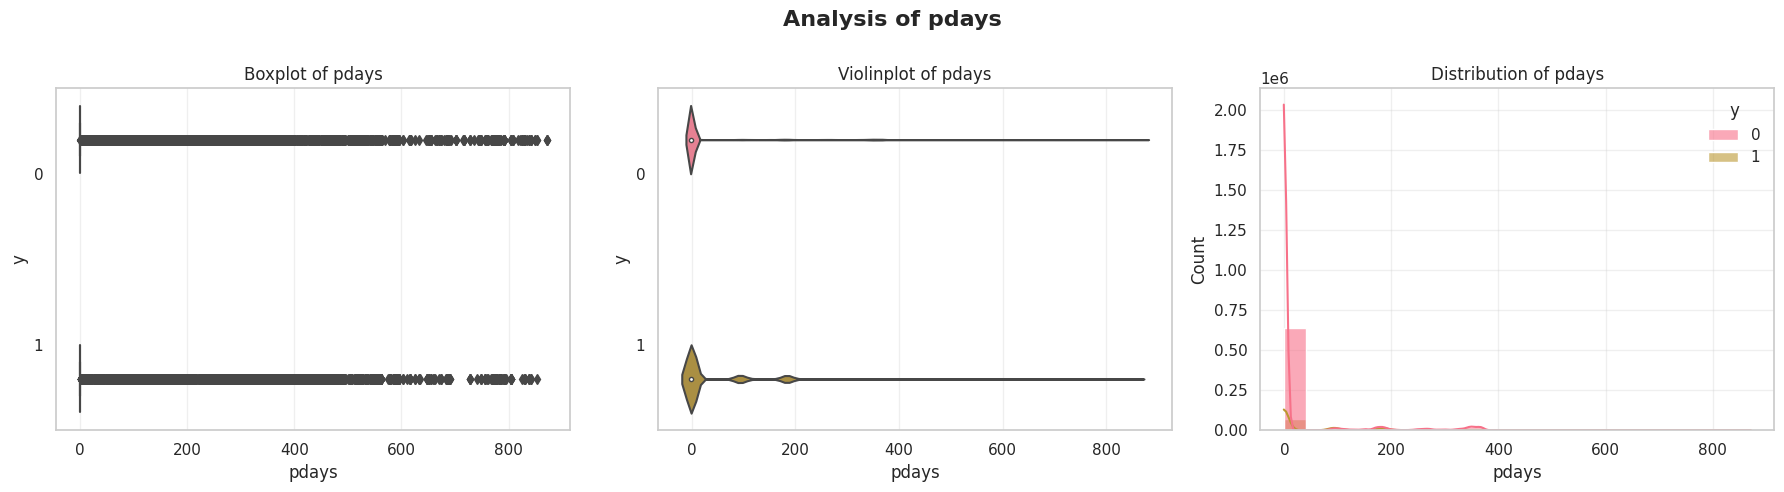

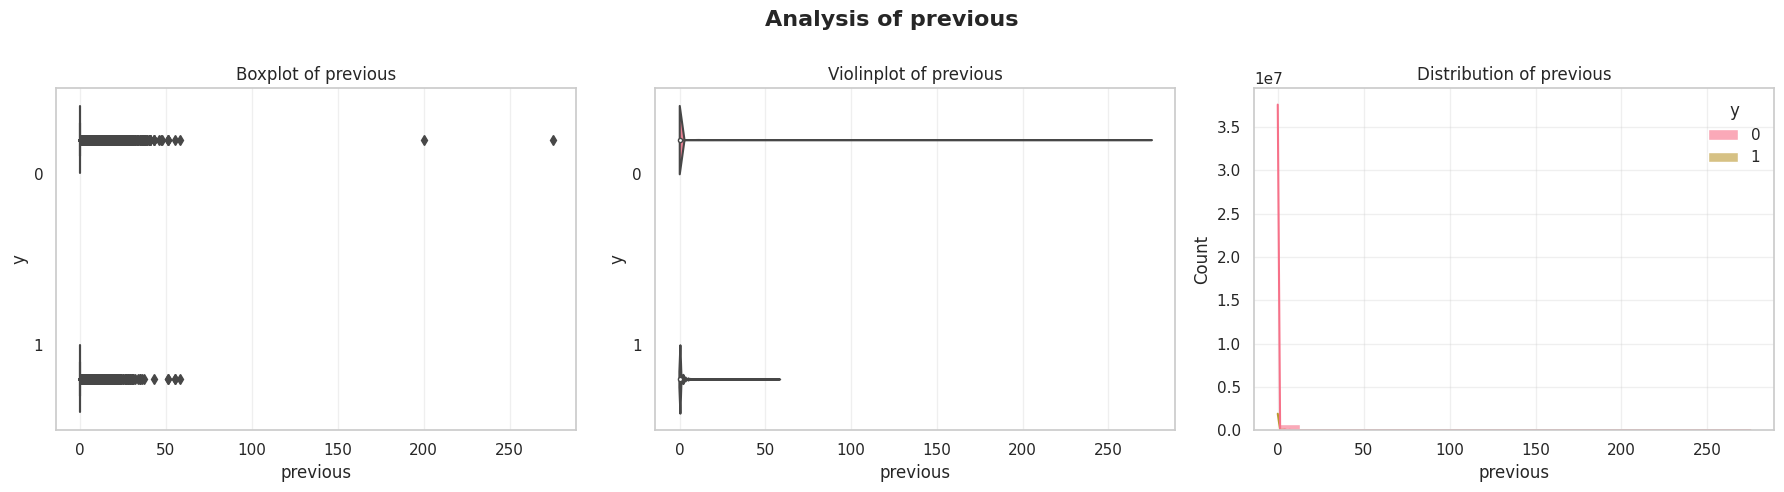

In [29]:
for feature in numerical_features:
    numerical_features_plot(train_df,feature,target)

In [30]:
def categorical_features_plot(df, feature):
    value_counts = df[feature].value_counts()
    
    top_n = min(10, len(value_counts))
    top_categories = value_counts.nlargest(top_n)
    
    df_plot = df[df[feature].isin(top_categories.index)]

    top_percentages = (top_categories / len(df)) * 100

    plt.figure(figsize=(16, 5))

    plt.subplot(1, 2, 1)
    sns.countplot(df_plot, x=feature, palette=sns.color_palette('viridis'))
    plt.title(f"Count Plot of{(' Top ' + str(top_n)) if len(value_counts) > 10 else ''} Categories of {feature}", size=16, fontweight='bold')
    plt.xticks(rotation=60)

    plt.subplot(1, 2, 2)
    plt.pie(
        top_percentages,
        labels=top_percentages.index,
        autopct=lambda pct: f"{pct:.2f}%",
        pctdistance=0.75
    )
    plt.gca().add_artist(plt.Circle((0, 0), 0.5, fc='w'))  # Donut hole
    plt.title(
        f"{('Top ' + str(top_n)) if len(value_counts) > 10 else ''} {feature} Categories as % of Full Dataset",
        size=16,
        fontweight='bold'
    )
    plt.ylabel("")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

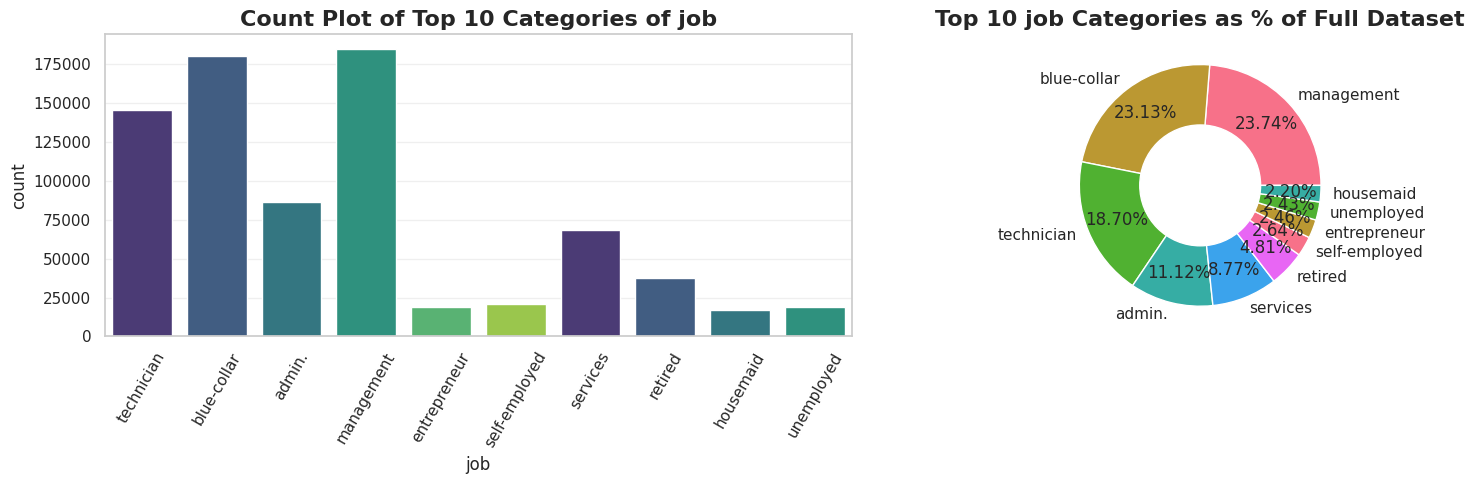

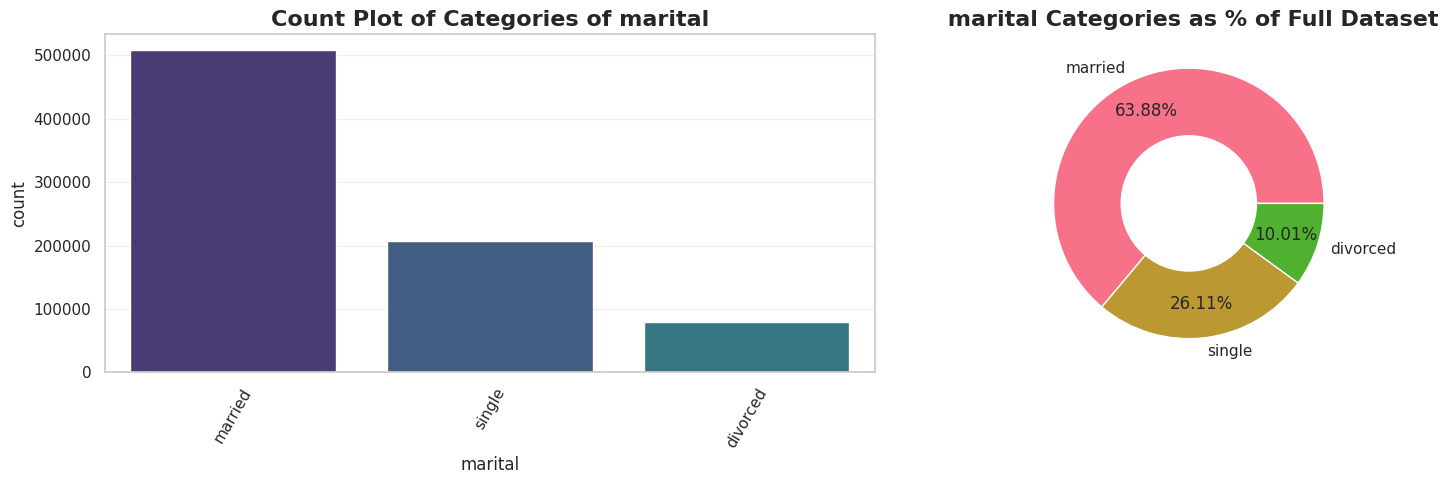

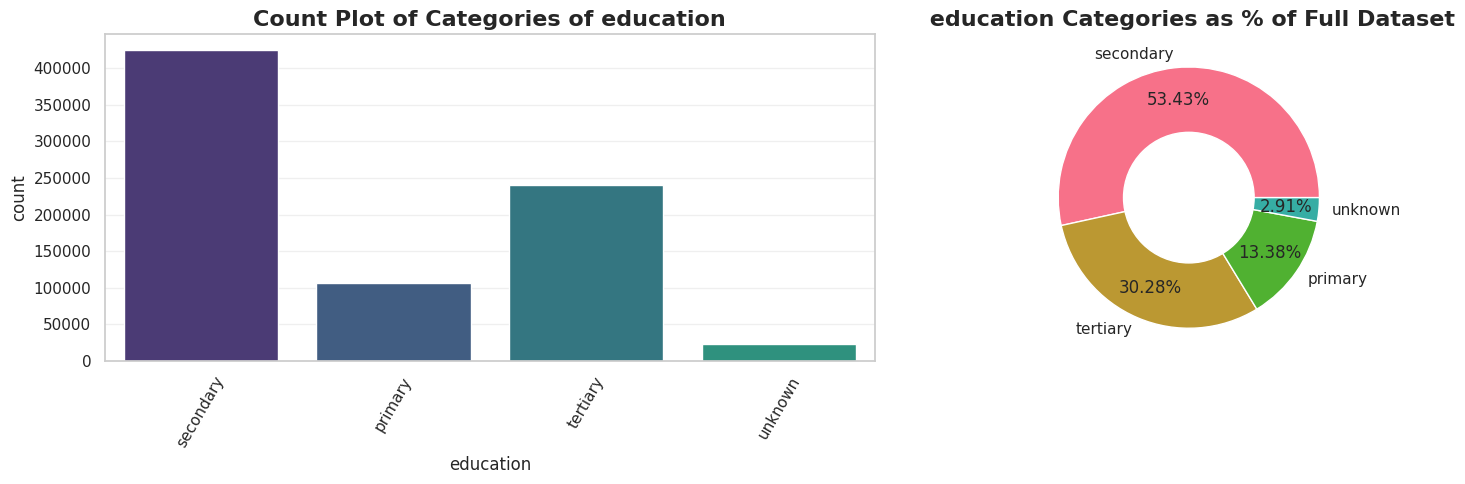

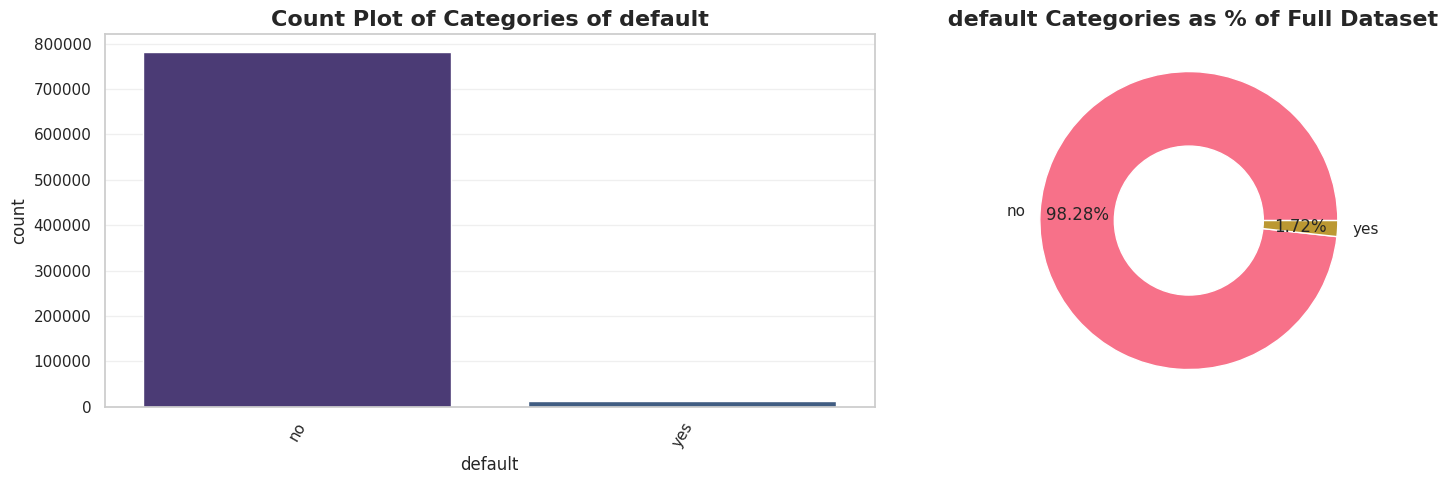

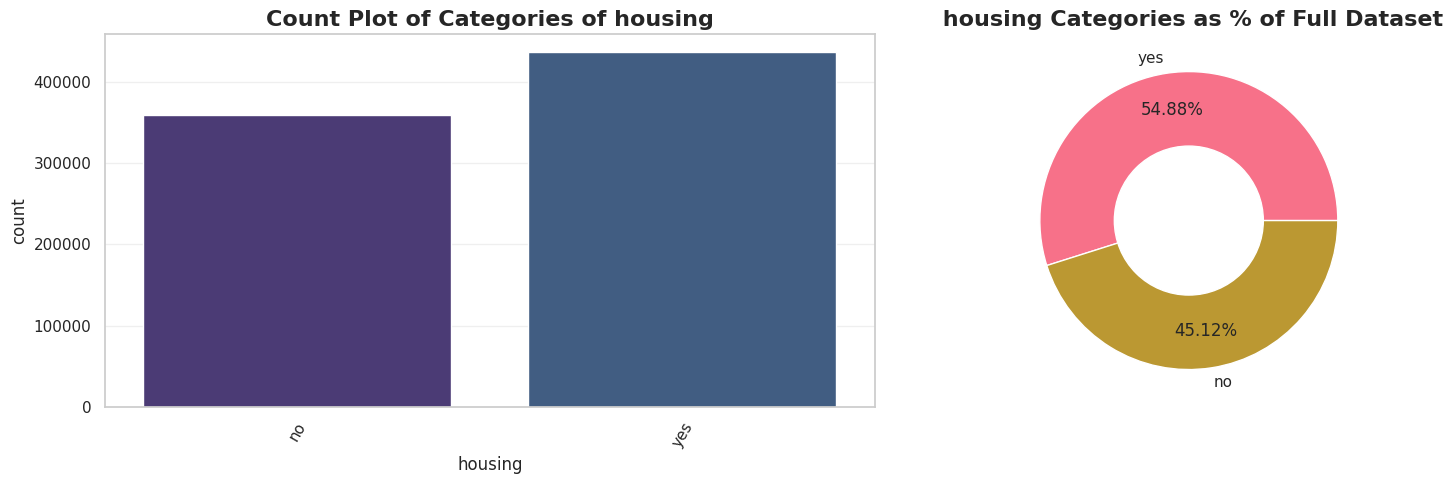

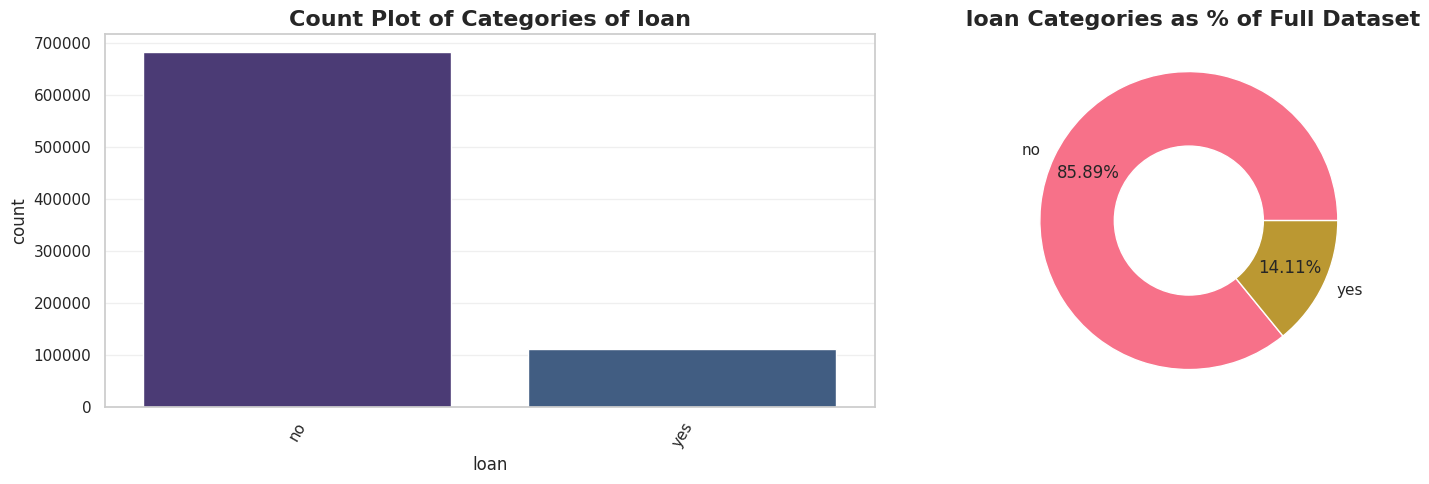

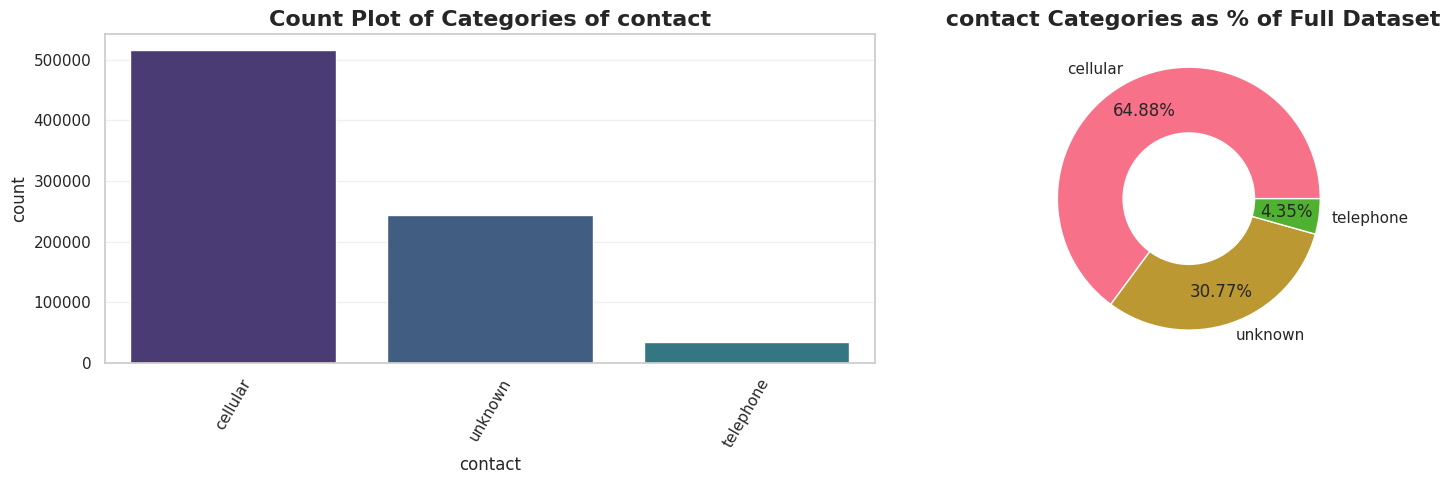

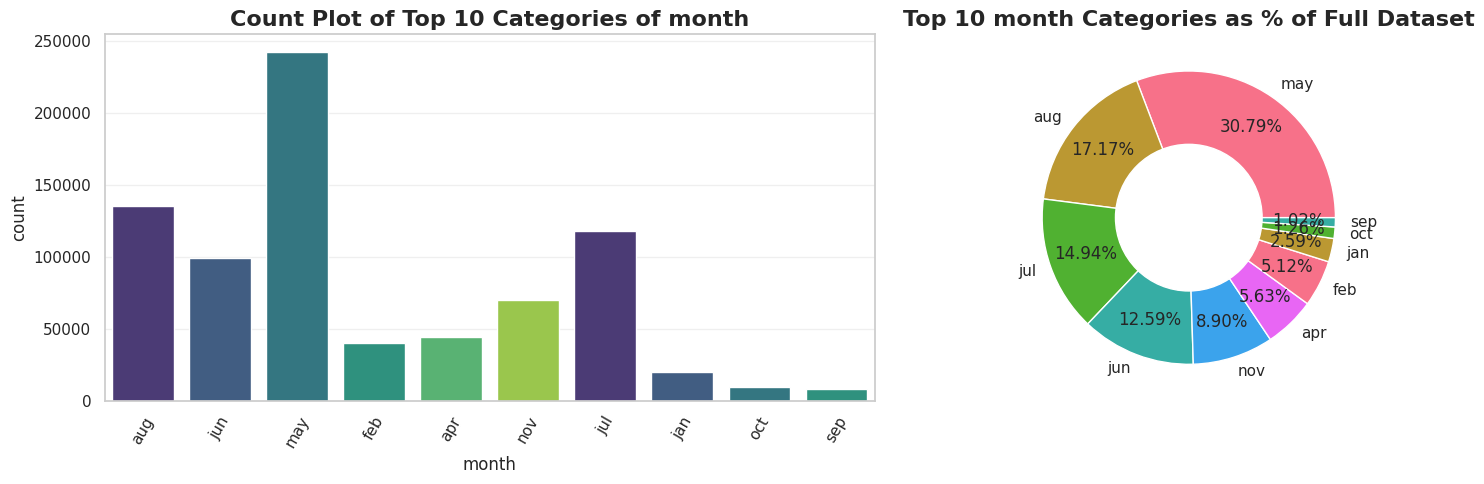

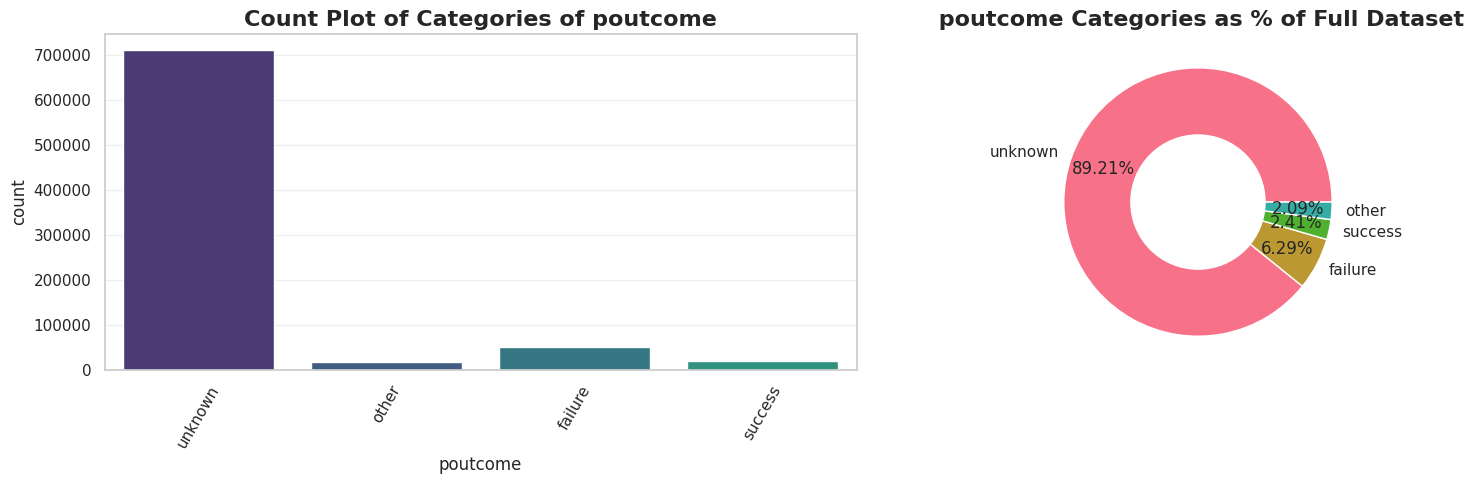

In [31]:
for feature in categorical_features:
    if feature == 'day':
        continue
    categorical_features_plot(train_df, feature)

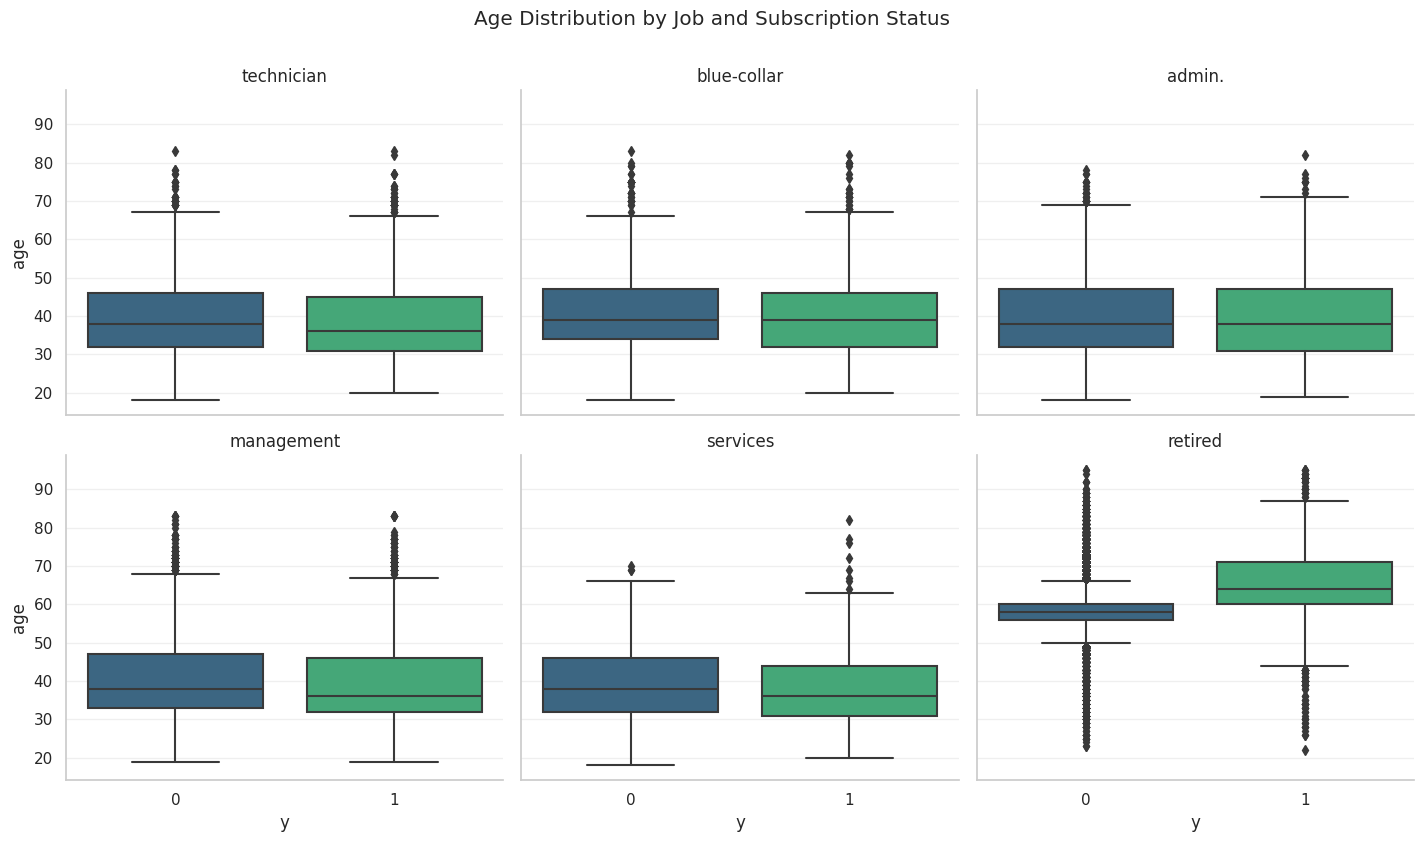

In [32]:
g = sns.FacetGrid(train_df[train_df['job'].isin(train_df['job'].value_counts().head(6).index)], 
                  col='job', col_wrap=3, height=4, aspect=1.2)
g.map_dataframe(sns.boxplot, x='y', y='age', palette='viridis')
g.set_titles("{col_name}")
g.fig.suptitle('Age Distribution by Job and Subscription Status', y=1.05)
plt.show()

In [33]:
def plot_categorical_heatmap(feature1, feature2):
    cross_tab = pd.crosstab(train_df[feature1], train_df[feature2], normalize='index') * 100
    plt.figure(figsize=(10, 6))
    sns.heatmap(cross_tab, annot=True, fmt='.1f', cmap='YlGnBu', linewidths=.5)
    plt.title(f'Percentage of Subscription by {feature1} and {feature2}')
    plt.ylabel(feature1)
    plt.xlabel(feature2)
    plt.show()

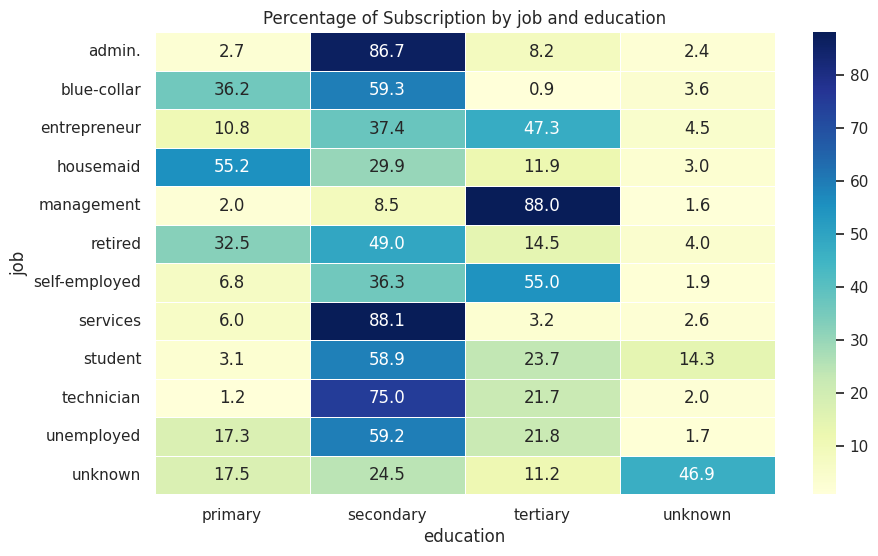

In [34]:
plot_categorical_heatmap('job', 'education')

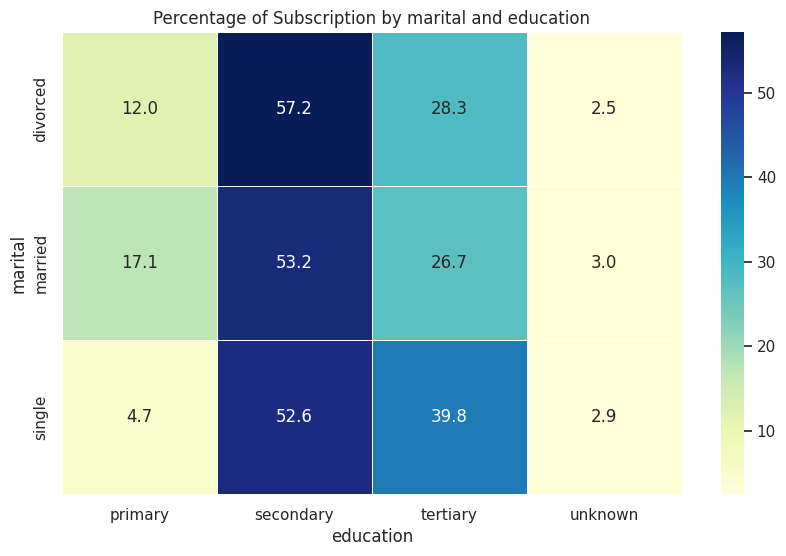

In [35]:
plot_categorical_heatmap('marital', 'education')


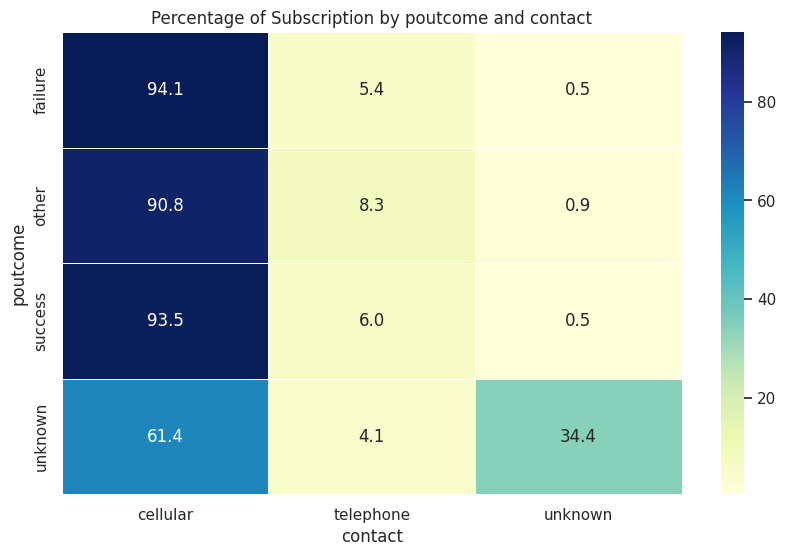

In [36]:
plot_categorical_heatmap('poutcome', 'contact')

In [37]:
def data_process(df): # Source: https://www.kaggle.com/code/haohuanchen/ps-s5e8-lightgb-model-a-simple-starter
    df = df.copy()
    
    def many_no(x):
        if x['default']=='no' and x['housing']=='no' and x['loan']=='no':
            return 21
        if x['default']=='no' and x['housing']=='no'\
        or x['default']=='no' and x['loan']=='no'\
        or x['housing']=='no' and x['loan']=='no':
            return 7
        if x['default']=='no' or x['housing']=='no' or x['loan']=='no':
            return 3
        return 0
    
    df['many_no']  = df.apply(lambda x: many_no(x), axis=1)
    
    return df

In [38]:
X = train_df.drop('y', axis=1)
y = train_df['y']

X_str = data_process(X).astype('str')
test_str = data_process(test_df).astype('str')

In [39]:
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score
from sklearn.base import clone

cat_clf = CatBoostClassifier(
    allow_writing_files=False,
    verbose=False,
    task_type='GPU',
    loss_function='CrossEntropy',
    use_best_model=True,
    cat_features=X_str.columns.to_list(),
    n_estimators=10000,
    learning_rate=0.1,
)

N_SPLITS = 5
skfold = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=0)
test_pred = np.zeros(len(test_str))
roc_scores = []

for fold, (train_idx, test_idx) in enumerate(skfold.split(X_str, y), 1):
    X_train, X_test = X_str.iloc[train_idx], X_str.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    model = clone(cat_clf)
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=200, verbose=500)
    
    y_pred = model.predict_proba(X_test)[:, 1]
    roc_score = roc_auc_score(y_test, y_pred)
    roc_scores.append(roc_score)

    test_pred += model.predict_proba(test_str)[:, 1]
    print(f"Fold {fold} -> ROC-AUC: {roc_score:.5f}")

print(f"Average Fold ROC-AUC: {np.mean(roc_scores):.5f} \xb1 {np.std(roc_scores):.5f}")

test_pred = test_pred / N_SPLITS

0:	learn: 0.5494370	test: 0.5482824	best: 0.5482824 (0)	total: 2.81s	remaining: 7h 47m 59s
500:	learn: 0.1386915	test: 0.1371022	best: 0.1370972 (494)	total: 31.6s	remaining: 9m 58s
1000:	learn: 0.1345675	test: 0.1358104	best: 0.1358104 (1000)	total: 1m	remaining: 9m 3s
1500:	learn: 0.1313219	test: 0.1352255	best: 0.1352255 (1500)	total: 1m 29s	remaining: 8m 26s
2000:	learn: 0.1284590	test: 0.1349716	best: 0.1349665 (1978)	total: 1m 58s	remaining: 7m 52s
bestTest = 0.1349009559
bestIteration = 2201
Shrink model to first 2202 iterations.
Fold 1 -> ROC-AUC: 0.97215
0:	learn: 0.5548723	test: 0.5537951	best: 0.5537951 (0)	total: 70.6ms	remaining: 11m 45s
500:	learn: 0.1386972	test: 0.1367138	best: 0.1367124 (499)	total: 28.9s	remaining: 9m 8s
1000:	learn: 0.1348052	test: 0.1355426	best: 0.1355426 (1000)	total: 57.9s	remaining: 8m 40s
1500:	learn: 0.1315251	test: 0.1349768	best: 0.1349768 (1500)	total: 1m 26s	remaining: 8m 12s
2000:	learn: 0.1286041	test: 0.1346358	best: 0.1346235 (1962)	to

In [40]:
sub = pd.read_csv("/kaggle/input/playground-series-s5e8/sample_submission.csv")
sub['y'] = test_pred
sub.to_csv("submission.csv", index=False)
sub.head()

,id,y
0,750000,0.0067
1,750001,0.1799
2,750002,0.0004
3,750003,0.0001
4,750004,0.0182
